# IEEE-CIS Fraud Detection

## Integrating machine learning to detect fraud

Industries and individuals are suffering from fraudulent damages. Implementing effective and accurate fraud prevention systems can save businesses and consumers millions of dollars. With the goal of improving customer experience, [IEEE Computational Intelligence Society](https://cis.ieee.org/) has partnered with payment service company, [Vesta Corporation](https://trustvesta.com/), to find more effective solutions for fraud prevention. 

In this project, we will be participating in this competition and using Kaggle's competition [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) machine dataset. The purpose of the competition is to use historical Vesta's real-world e-commerce transaction to predict whether a transaction is fraud or not. We will employ supervised classification models for this task. 
 * __Supervised__: The goal is to train a model to learn from features to predict the probability of an online fraudulent transaction given labels in the _isFraud_ column. 
 * __Classification__: The label is a binary variable: 0 (not fraud), 1 (fraud)
 
### Overview of Data
There are a total of 5 files: 
 * 1 example submission files 
 * 2 transaction files (test and train)
 * 2 identity files (test and train) 

Since the transaction files include our target variable _isFraud_ column, we will predominately be exploring transaction files. This will let us establish a baseline that we can then improve upon. 


## Metric ROC AUC

Before we begin, let's get an understanding of how each submission is evaluated. For this competition, models are being judged by the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which measures the true positive rate versus the false positive rate. 

ROC AUC measures the probability between 0 and 1. While a score of 0.5 indicates random guessing, better models will receive a higher score. Setting accuracy as the metric isn't recommend since real-world datasets have imbalanced classes. The model will likely be good in predicting the dominant class and misclassify the minority class. In this project, we can anticipate that most transactions are not fraud. If we were to measure based on accuracy, our model would preform well in detecting non-fraud related transactions. That wouldn't be the most effective way in preventing fraud if our model is not good at identifying it. Thus, ROC AUC is used to reflect the accuracy of a classifier.

# Read in Data



In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Decision Trees
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image
import pydotplus
import graphviz

# Random Forests 
from sklearn import ensemble

# SVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Import data
from sqlalchemy import create_engine
import warnings

In [2]:
# List files available
test = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/test_transaction.csv')

train = pd.read_csv('/Users/tsawaengsri/Desktop/Data Science Courses/Datasets/ieee-fraud-detection/train_transaction.csv')


In [3]:
# Format column headings 
test.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')
train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

Index(['transactionid', 'isfraud', 'transactiondt', 'transactionamt',
       'productcd', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'v330', 'v331', 'v332', 'v333', 'v334', 'v335', 'v336', 'v337', 'v338',
       'v339'],
      dtype='object', length=394)

In [4]:
# Training data
print('Training transaction data shape: ', train.shape)
train.head()

Training transaction data shape:  (590540, 394)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The training data has 590,540 observations (each one a separate online transaction) and 394 attributes including the target variable we want to predict.

In [5]:
print('Testing transaction data shape: ', test.shape)
test.head()

Testing transaction data shape:  (506691, 393)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The testing data contains 506,691 observations and 393 attributes. This dataset is smaller than the training set and does not contain the target variable. 

# Exploratory Data Analysis 
Exploratory Data Analysis (EDA) is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods. The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. 

### Examine the Distribution of the Target Column

We will begin EDA by exploring individual variables, particularly our target variable, _isFraud_. The target is what we are asked to predict: either a 0 for non-fraud transactions, or a 1 for fraud transaction. First, let's examine the number of transactions falling into each category.

In [6]:
train['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

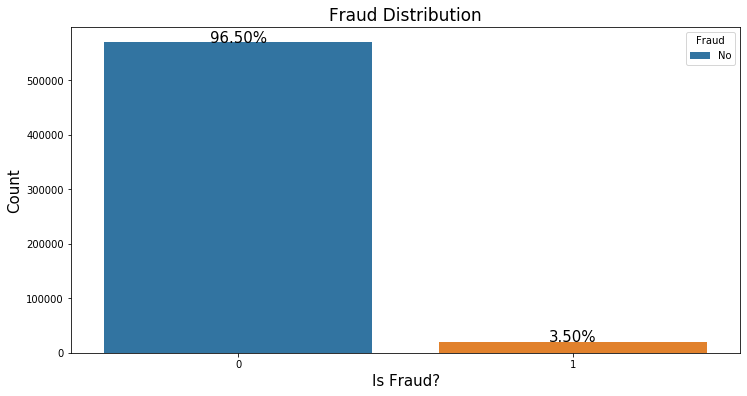

In [7]:
# Plot target variable
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'isFraud', data = train)
g.set_title("Fraud Distribution", fontsize = 17)
g.set_xlabel("Is Fraud?", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
plt.legend(title='Fraud', labels=['No', 'Yes'])

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train) * 100),
            ha="center", fontsize=15) 

We can see an imbalanced class problem from the value count and histogram. Majority of transactions were non-fraudlent transactions. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

### Missing Values
Now, we will take a look at missing values in each column. Due to the volume of the data, we will look at different sections of the data.

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(train)

Your selected dataframe has 394 columns.
There are 374 columns that have missing values.


,Missing Values,% of Total Values
dist2,552913,93.6
D7,551623,93.4
D13,528588,89.5
D14,528353,89.5
D12,525823,89.0
D6,517353,87.6
D9,515614,87.3
D8,515614,87.3
V157,508595,86.1
V163,508595,86.1


We can observe that there are missing values in majority of the columns. There appears to be a pattern of missing values in columns V122-V163. Due to  the limited information given on these columns for privacy issues, it is difficult to determine if these columns offer helpful information for predicting fraud.

We may impute these missing values later or use models that can handle missing values.

### Column Types
In this section, we will take a look at the numbers of columns of each data type. 

In [10]:
# Number of each type of column
train.dtypes.value_counts()

float64    376
object      14
int64        4
dtype: int64

Let's now look at the number of unique entries in each of the object (categorical) columns.

In [11]:
# Number of unique classes in each object column
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

ProductCD         5
card4             4
card6             4
P_emaildomain    59
R_emaildomain    60
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will encode these attributes.

### Anomalies 
We'll be searching for anomalies within the data.  These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the describe method. 


In [12]:
# Statistics 
train.describe()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,5.905400e+05,590540.000000,5.905400e+05,590540.000000,590540.000000,581607.000000,588975.000000,586281.000000,524834.000000,524834.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,3.282270e+06,0.034990,7.372311e+06,135.027176,9898.734658,362.555488,153.194925,199.278897,290.733794,86.800630,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,1.704744e+05,0.183755,4.617224e+06,239.162522,4901.170153,157.793246,11.336444,41.244453,101.741072,2.690623,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,2.987000e+06,0.000000,8.640000e+04,0.251000,1000.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,3.134635e+06,0.000000,3.027058e+06,43.321000,6019.000000,214.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,3.282270e+06,0.000000,7.306528e+06,68.769000,9678.000000,361.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,3.429904e+06,0.000000,1.124662e+07,125.000000,14184.000000,512.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,3.577539e+06,1.000000,1.581113e+07,31937.391000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


Inital observations:
 - Transaction amount varies from /$0.25 to /$31,937
 - Not sure why card 1,2,3,5 are numeric
 - A lot of V columns are 0 

In [13]:
# Categorical Statistics 
train.describe(include=['object'])

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
count,590540,588963,588969,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288
unique,5,4,4,59,60,2,2,2,3,2,2,2,2,2
top,W,visa,debit,gmail.com,gmail.com,T,T,T,M0,F,F,F,F,T
freq,439670,384767,439938,228355,57147,319415,285468,251731,196405,132491,227856,211374,155251,205656


Inital observations:

- Product code W is the most popular item
- People pay with mostly debit visa
- Gmail is the most popular email domain
- M4 is not similar to other M columns

It is difficult to detect an anomaly from the statistics table. Let's explore the interaction between features and our target variable to see if we can find something interesting. 

## Multivariable Analysis
Now, let's explore how our target variable interacts with other features. 

_Categorical Features_
 * ProductCD: product code
 * card4, card6: card information 
 * P_emaildomain: purchaser email domain
 * R_emaildomain: recipient email domain
 * M1 - M9: match (names on card, address, etc)
 
_Numeric Features_
 * TransactionDT: timedelta from a given reference datetime
 * TransactionAMT: transaction payment amount in USD
 * card1-3, card5: card information 
 * dist: distance
 * addr1, addr2: address 
 * C1-C4: counting
 * D1-D15: timedelta (time between previous transaction)
 * V1-V339: Vesta engineered features


 
### Categorical Variables 
We'll start with exploring categorical variables. 

In [14]:
# Function to visualize categorical variables
def visualize_cat_var(variable, df=train):
    df[variable].fillna("NA", inplace=True)
    variable_fraud_rate = df.groupby(variable)['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
    
    plt.figure(figsize=(12,6))

    g = sns.countplot(x = variable, data = train, order = variable_fraud_rate.index)
    g.set_title('{} Count'.format(variable), fontsize = 15)
    g.set_xlabel("{}".format(variable), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    plt.xticks(rotation= "vertical")

    r = g.twinx()
    r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
    r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

#### Product CD
Product code represent the product for each transaction.
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”

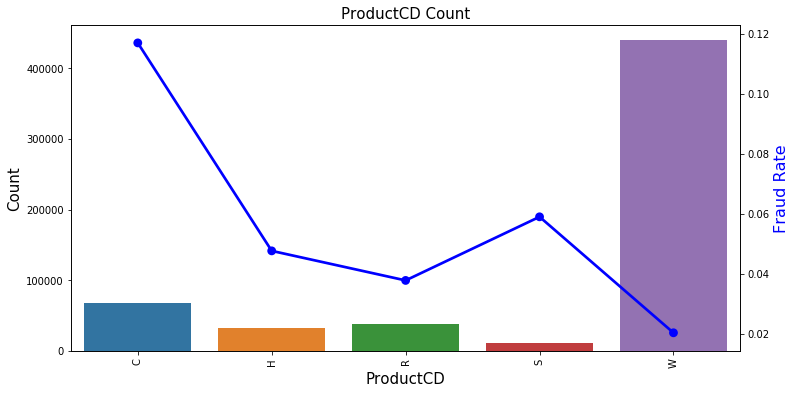

In [15]:
visualize_cat_var('ProductCD')

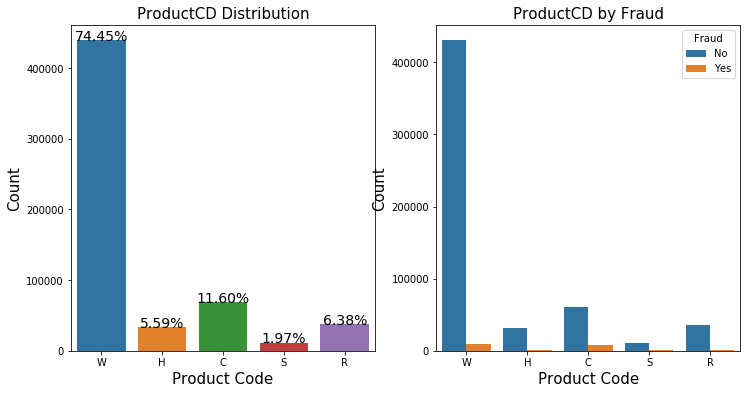

In [16]:
# Plot Product CD Distribution 
plt.figure(figsize=(12,6))

total = len(train)

plt.subplot(1,2,1)
g = sns.countplot(x = 'ProductCD', data = train)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(1,2,2)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

Product Code C was the most occuring product category and had the highest count of fraud. 

In [17]:
train[train['isFraud'] == 1]['ProductCD'].value_counts(normalize = True)

W    0.434061
C    0.387553
H    0.076175
R    0.069012
S    0.033199
Name: ProductCD, dtype: float64

Product C makes up 67% of transaction fraud cases. That is more than double the amount of fraud for other product categories. 

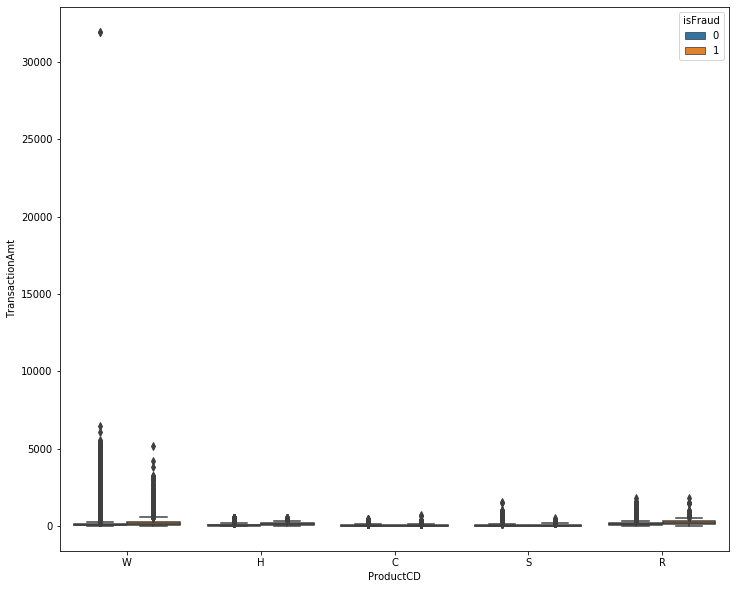

In [18]:
plt.figure(figsize=(12,10))
sns.boxplot(x = 'ProductCD', y = 'TransactionAmt', hue = 'isFraud', data = train)

Product C items cost less than other product code items. 

#### Card Type
These columns represent payment card information, such as card type, card category, issue bank, country, etc.

Card 1, 2, 3, and 5 are numeric variables in this dataset. However, the numeric values are probably represent categories.

In [19]:
card_cols = [c for c in train.columns if 'card' in c]
train[card_cols].head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


In [20]:
train.loc[:,'card1':'card5'].nunique()

card1    13553
card2      500
card3      114
card4        4
card5      119
dtype: int64

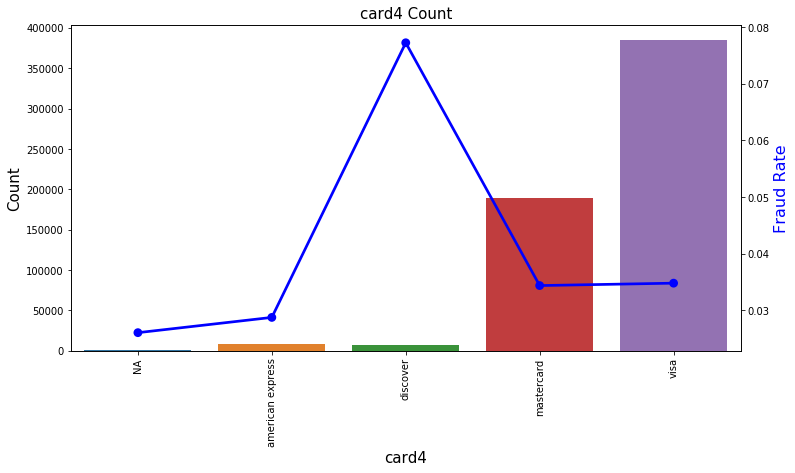

In [21]:
visualize_cat_var('card4')

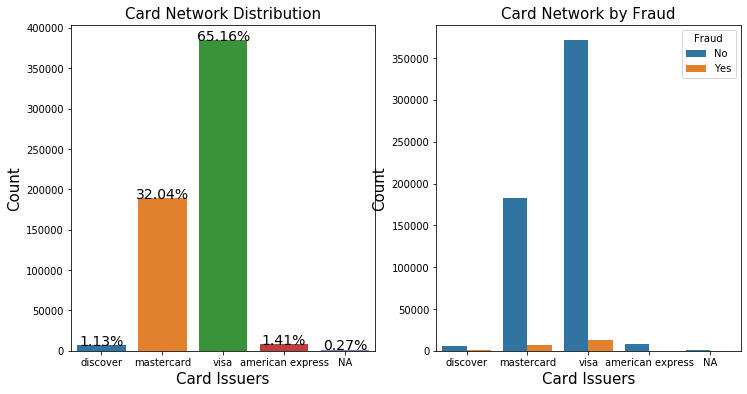

In [22]:
# Plot Card 4
plt.figure(figsize=(12,6))

total = len(train)

plt.subplot(1,2,1)
g = sns.countplot(x = 'card4', data = train)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(1,2,2)
g1 = sns.countplot(x='card4', hue='isFraud', data=train)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

Visa card accounts for the highest instances of fraud, but this also because visa is the most popular card type.

In [23]:
train[train['isFraud'] == 1]['card4'].value_counts(normalize = True)

visa                0.647195
mastercard          0.314378
discover            0.024875
american express    0.011567
NA                  0.001984
Name: card4, dtype: float64

In [24]:
train.groupby('card4')['isFraud'].value_counts(normalize = True)

card4             isFraud
NA                0          0.974001
                  1          0.025999
american express  0          0.971302
                  1          0.028698
discover          0          0.922718
                  1          0.077282
mastercard        0          0.965669
                  1          0.034331
visa              0          0.965244
                  1          0.034756
Name: isFraud, dtype: float64

Visa accounts for 61% of all fraud occurences. However, when normalized by total number of each type, Visa have fraud rate of only 8%, lower than Mastercard and same as Discovercard. Only American Express have significantly lower fraud rate compare to others.

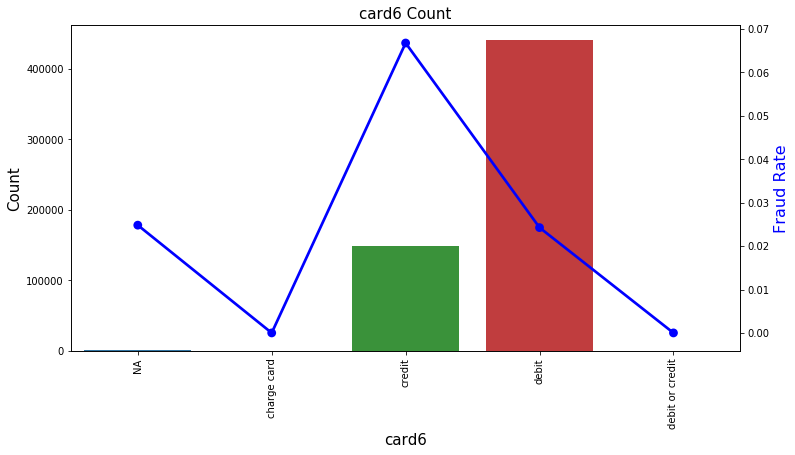

In [25]:
visualize_cat_var('card6')

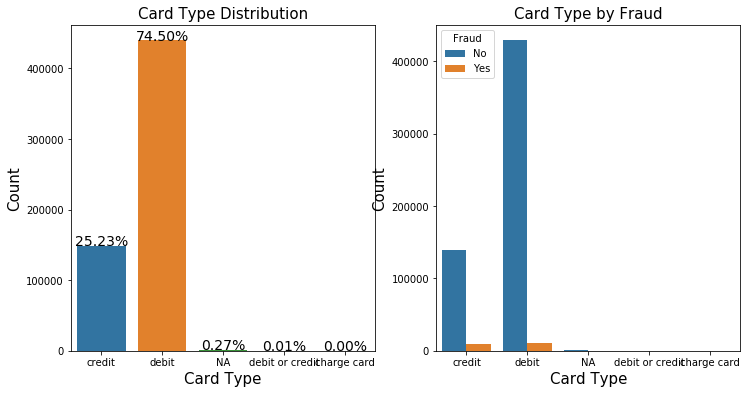

In [26]:
# Card 6
plt.figure(figsize=(12,6))

total = len(train)

plt.subplot(1,2,1)
g = sns.countplot(x = 'card6', data = train)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(1,2,2)
g1 = sns.countplot(x='card6', hue='isFraud', data=train)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])

In [27]:
train.groupby('card6')['isFraud'].value_counts(normalize = True)

card6            isFraud
NA               0          0.975175
                 1          0.024825
charge card      0          1.000000
credit           0          0.933215
                 1          0.066785
debit            0          0.975737
                 1          0.024263
debit or credit  0          1.000000
Name: isFraud, dtype: float64

The number of card type are fairly simiar, and so does the fraud cases.

#### Email Domain
P_ and (R_) emaildomain: purchaser and recipient email domain “ certain transactions don't need recipient, so R_emaildomain is null.”


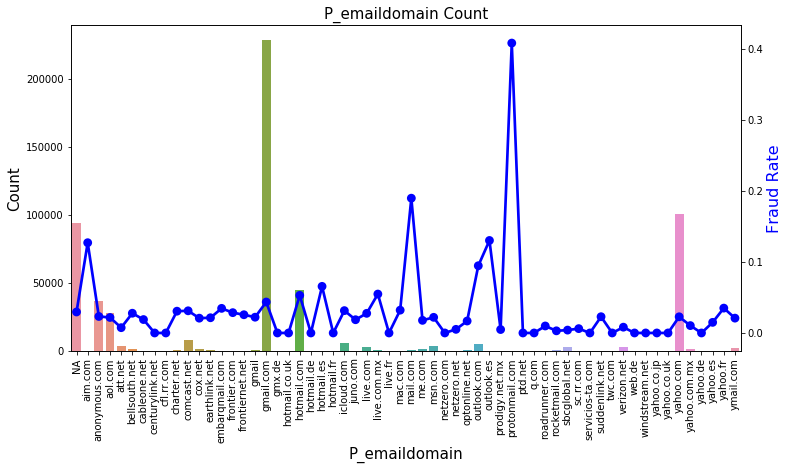

In [28]:
visualize_cat_var('P_emaildomain')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text xticklabel objects>)

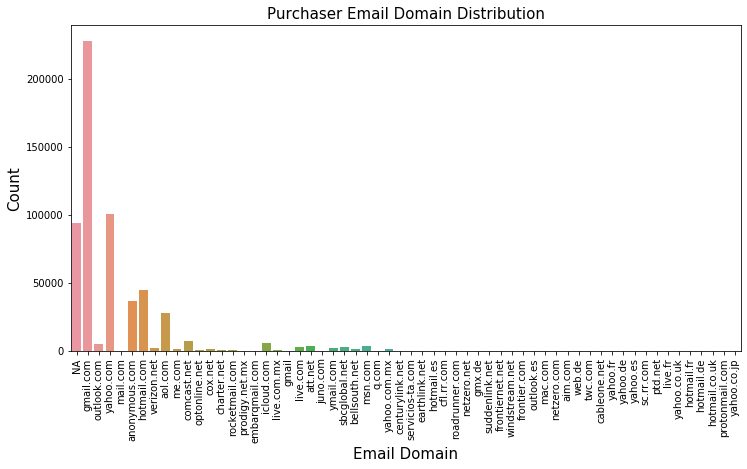

In [29]:
# Plot purchaser email domain
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')

Text(0, 0.5, 'Fraud Rate')

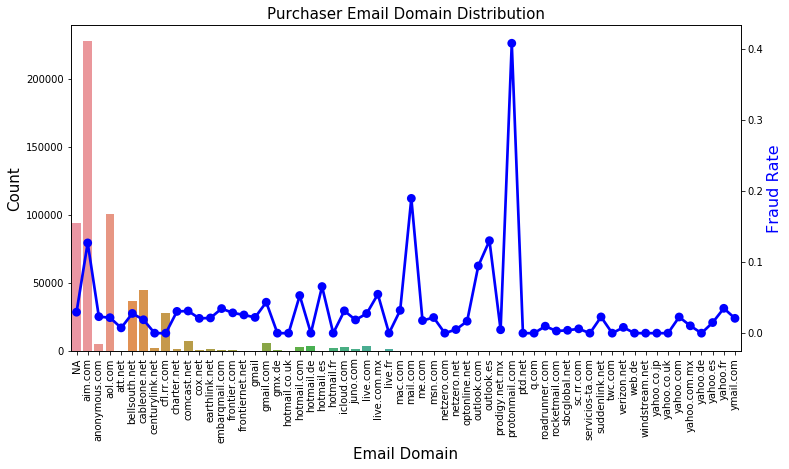

In [31]:
P_emaildomain_fraud_rate = train.groupby('P_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = P_emaildomain_fraud_rate.index, y = P_emaildomain_fraud_rate, color = 'blue')
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

Protonmail returns an exemely high fraud rate. Almost 80% of transactions from purchaser using protonmail.com were label fraud.

In [33]:
# Protonmail fraud rate
protonmail_fraud = len(train[(train['P_emaildomain'] == "protonmail") & (train['isFraud'] == 1)])
protonmail_non_fraud = len(train[(train['P_emaildomain'] == "protonmail") & (train['isFraud'] == 0)])

protonmail_fraud_rate = protonmail_fraud/ (protonmail_fraud + protonmail_non_fraud)
print("Number of protonmail fraud transactions:", protonmail_fraud)
print("Number of protonmail non-fraud transactions:", protonmail_non_fraud)
print("Protonmail fraud rate:", protonmail_fraud_rate)

ZeroDivisionError: division by zero

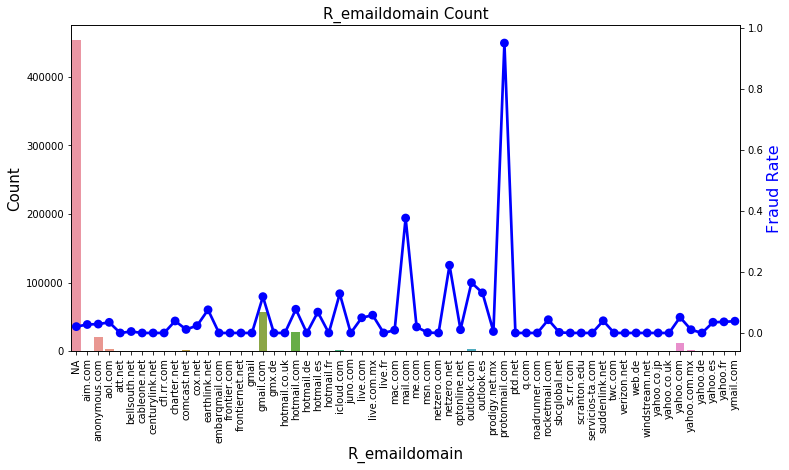

In [34]:
visualize_cat_var('R_emaildomain')

Text(0, 0.5, 'Fraud Rate')

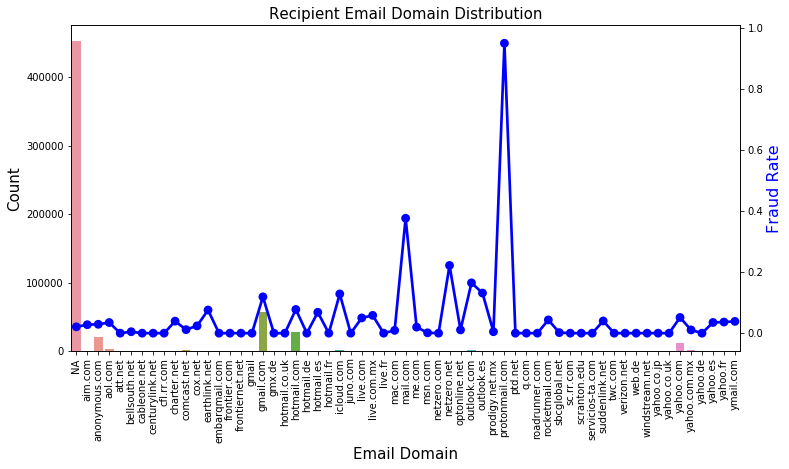

In [36]:
R_emaildomain_fraud_rate = train.groupby('R_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_emaildomain', data = train, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")

Similar to purchaser email domain, protonmail recieved the most fraud rate.

#### M1-M9
M columns represent matches such as names on card and address, etc.

In [37]:
m_cols = [c for c in train.columns if c[0] == 'M']
train[m_cols].head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


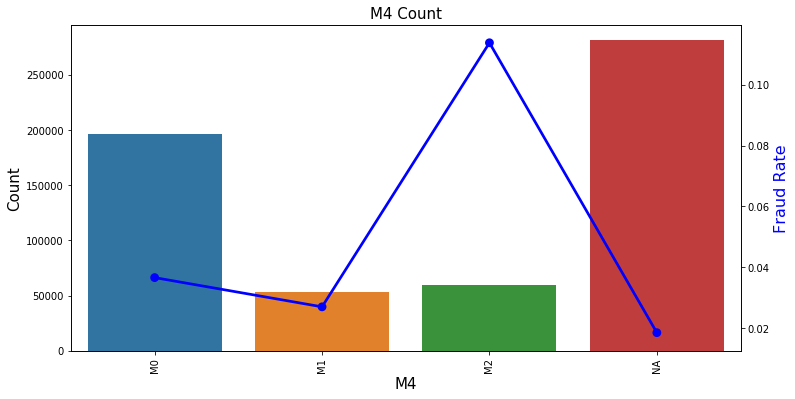

In [38]:
visualize_cat_var('M4')

Not much variation in fraud rate between M0, M1, and M2 in M4

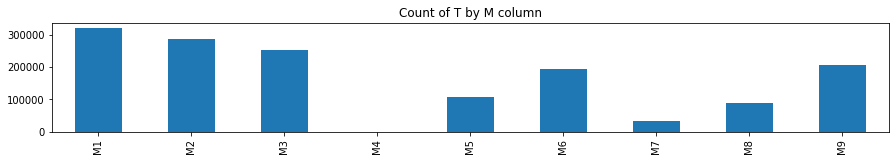

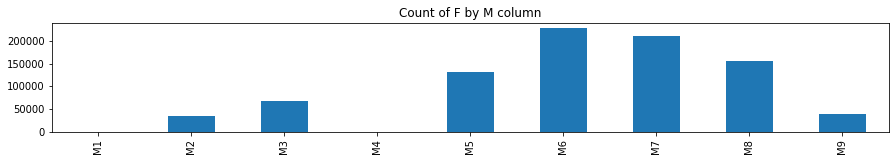

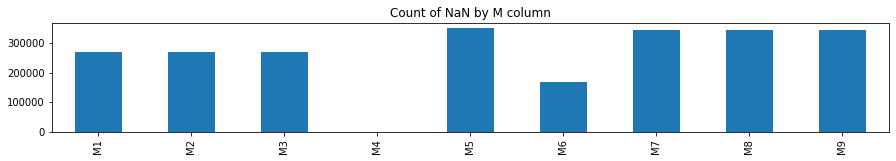

In [40]:
(train[m_cols] == 'T').sum().plot(kind='bar',
                                              title='Count of T by M column',
                                              figsize=(15, 2))
plt.show()
(train[m_cols] == 'F').sum().plot(kind='bar',
                                              title='Count of F by M column',
                                              figsize=(15, 2))
plt.show()
(train[m_cols].isna()).sum().plot(kind='bar',
                                              title='Count of NaN by M column',
                                              figsize=(15, 2))
plt.show()

### Numerical Features
Now, we will continue EDA by exploring the interaction between our target variable and numerical variables. 

#### TransactionDT
This is the time delta from a given reference datetime (not an actual timestamp)
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”

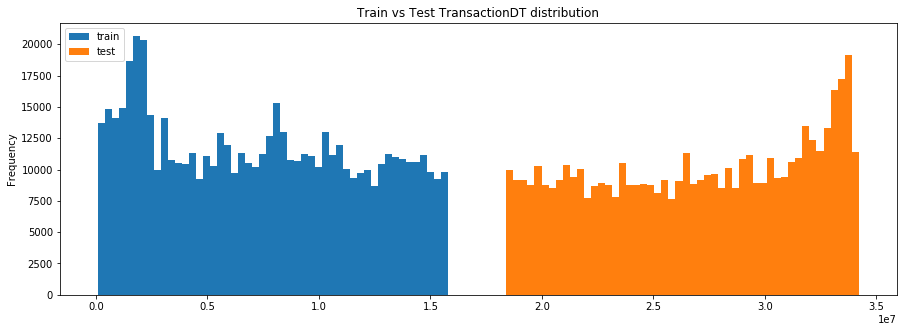

In [41]:
train['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

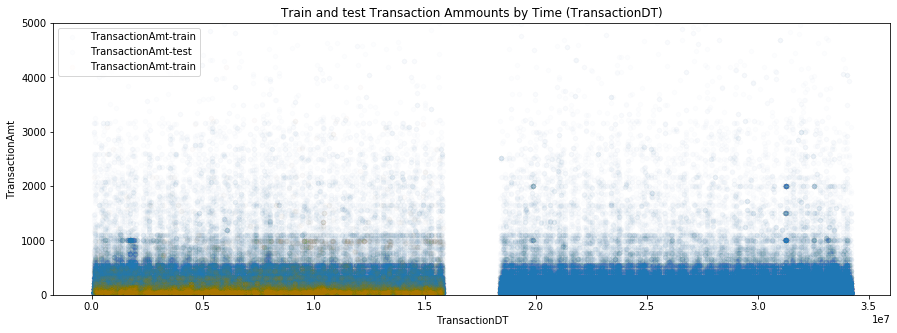

In [43]:
ax = train.plot(x='TransactionDT',
                       y='TransactionAmt',
                       kind='scatter',
                       alpha=0.01,
                       label='TransactionAmt-train',
                       title='Train and test Transaction Ammounts by Time (TransactionDT)',
                       ylim=(0, 5000),
                       figsize=(15, 5))
test.plot(x='TransactionDT',
                      y='TransactionAmt',
                      kind='scatter',
                      label='TransactionAmt-test',
                      alpha=0.01,
                       ylim=(0, 5000),
                      ax=ax)
# Plot Fraud as Orange
train.loc[train['isFraud'] == 1] \
    .plot(x='TransactionDT',
         y='TransactionAmt',
         kind='scatter',
         alpha=0.01,
         label='TransactionAmt-train',
         title='Train and test Transaction Ammounts by Time (TransactionDT)',
         ylim=(0, 5000),
         color='orange',
         figsize=(15, 5),
         ax=ax)
plt.show()

#### Transaction Amount
This is the transaction payment amount in USD. <br>
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”

Let's take the log to treat the right skew of the transaction distribution. 

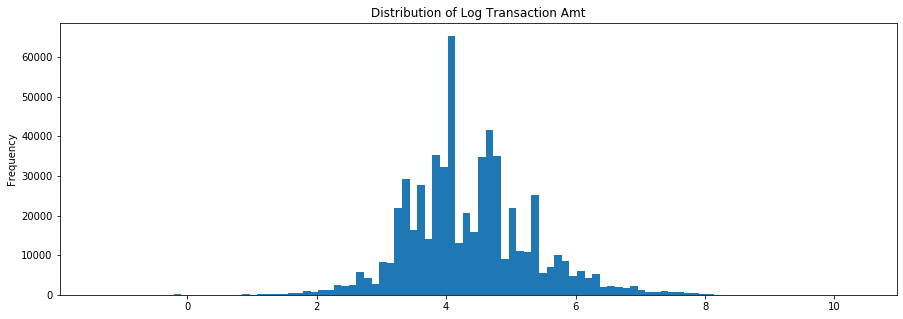

In [44]:
train['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

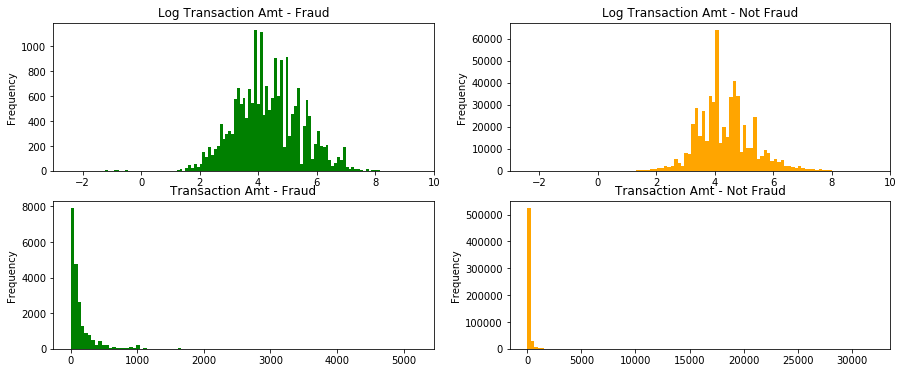

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 6))
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Fraud',
          color='green',
          xlim=(-3, 10),
         ax= ax1)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'].apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='Log Transaction Amt - Not Fraud',
          color='orange',
          xlim=(-3, 10),
         ax=ax2)
train.loc[train['isFraud'] == 1] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Fraud',
          color='green',
         ax= ax3)
train.loc[train['isFraud'] == 0] \
    ['TransactionAmt'] \
    .plot(kind='hist',
          bins=100,
          title='Transaction Amt - Not Fraud',
          color='orange',
         ax=ax4)
plt.show()


#### Distance 1 and 2
This can be interpeted as distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.

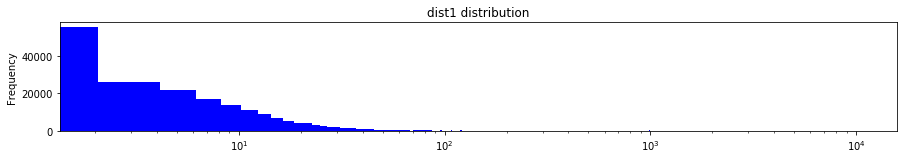

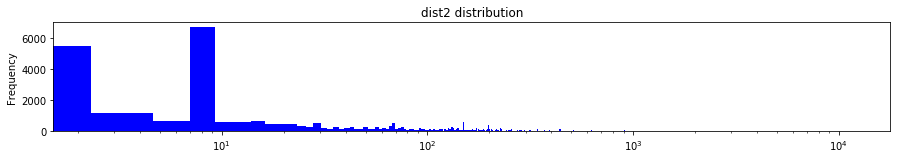

In [47]:
train['dist1'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist1 distribution',
                                color='blue',
                                logx=True)
plt.show()
train['dist2'].plot(kind='hist',
                                bins=5000,
                                figsize=(15, 2),
                                title='dist2 distribution',
                                color='blue',
                                logx=True)
plt.show()

#### Address 
The address columns refer to the purchaser information. _Addr1_ is the billing region and _addr2_ is the billing country.

In [48]:
print(' addr1 - has {} NA values'.format(train['addr1'].isna().sum()))
print(' addr2 - has {} NA values'.format(train['addr2'].isna().sum()))

 addr1 - has 65706 NA values
 addr2 - has 65706 NA values


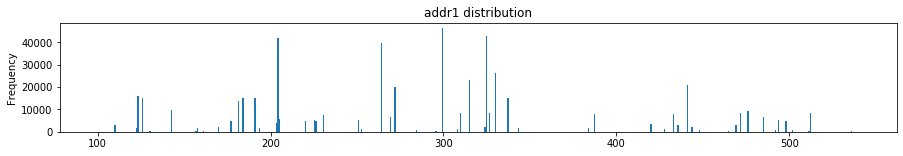

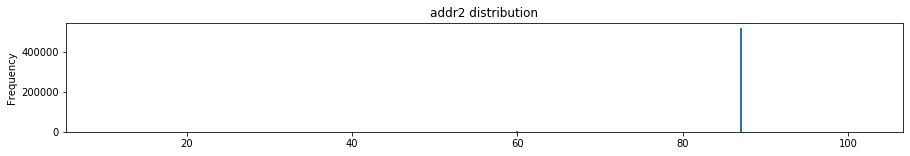

In [49]:
train['addr1'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr1 distribution')
plt.show()
train['addr2'].plot(kind='hist', bins=500, figsize=(15, 2), title='addr2 distribution')
plt.show()

There appears to be many missing address for the second column. 

#### C1 - C14
C columns are counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

In [50]:
c_cols = [c for c in train if c[0] == 'C']
train[c_cols].head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0


#### D1-D9
D columns are timedelta, such as days between previous transaction, etc.

In [51]:
d_cols = [c for c in train if c[0] == 'D']
train[d_cols].head()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15
0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0
1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### V1-V339
These are Vesta engineered rich features, including ranking, counting, and other entity relations.

“For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.”

"All Vesta features were derived as numerical. Some of them are count of orders within a clustering, a time-period or condition, so the value is finite and has ordering (or ranking). I wouldn't recommend to treat any of them as categorical. If any of them resulted in binary by chance, it maybe worth trying."

In [52]:
v_cols = [c for c in train if c[0] == 'V']
train[v_cols].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
train[v_cols].describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,...,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000
mean,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,...,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882
std,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,...,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,25.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,8.000000,9.000000,6.000000,6.000000,9.000000,9.000000,8.000000,8.000000,4.000000,...,55.000000,160000.000000,160000.000000,160000.000000,55125.000000,55125.00000,55125.000000,104060.000000,104060.000000,104060.000000


In [54]:
train['v_mean'] = train[v_cols].mean(axis=1)

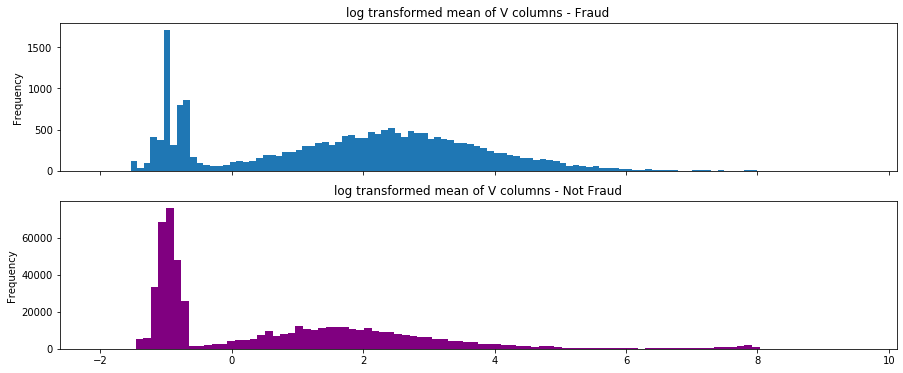

In [56]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))
train.loc[train['isFraud'] == 1]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Fraud',
          ax=ax1)
train.loc[train['isFraud'] == 0]['v_mean'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          title='log transformed mean of V columns - Not Fraud',
          color='purple',
          ax=ax2)
plt.show()

Interesting that there are negative components of the mean of V columns.

### Correlation 
To determine which explanatory variables we might select for our prediction model, we will explore the correlation between _isFraud_ and other variables. Correlation refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable.


In [ ]:
# Find correlations with the target and sort
corr = train.corr()['isFraud'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', corr.tail(15))
print('\nMost Negative Correlations:\n', corr.head(15))

We'll take a look into V and D columns.

### Encoding Categorical Variables
Before we continue, most machine learning models cannot handle categorical variables well. Therefore, we will have to encode (represent) these variables as numbers before modeling. The two main encoding methods are: 
 * __Label encoding__: assign each unique category in a categorical variable with an integer. No new columns are created.
 * __One-hot encoding__: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns.
 
The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. 

For this project, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. 

In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train:
    if train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train[col])
            # Transform both training and testing data
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

In [ ]:
# One-hot encoding of categorical variables
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

### Aligning Training and Testing Data
There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to align the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set axis = 1 to align the dataframes based on the columns and not on the rows!

In [ ]:
train_labels = train['isFraud']

# Align the training and testing data, keep only columns present in both dataframes
train, test = train.align(test, join = 'inner', axis = 1)

# Add the target back in
train['isFraud'] = train_labels

print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we will try dimensionality reduction. 

COMMENT on statistics

## Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will out findings to select a set of features for our model. 

### Add New Features 